In [1]:
import os
import re
import yaml
import pickle

import ipyplot
import numpy as np
import pandas as pd

import tensorflow as tf

import seaborn as sns
from matplotlib import pyplot as plt

# Data

In [2]:
cd ../../src

[Errno 2] No such file or directory: '../../src'
/Users/cock/kDrive/PhD/Projects/Labs/beerslaw-lab/notebooks/beerslaw/8 - timelines


In [3]:
experiment_path = '../experiments/incremental/fourth round/stateaction_secondslstm/binconcepts/lstm/raw_full/2021_12_27_0/'

# Gridsearch folds
gs_file = os.listdir(experiment_path + '/gridsearch results/')[0]
with open(experiment_path + '/gridsearch results/' + gs_file, 'rb') as fp:
    gs = pickle.load(fp)
    gs = gs.get_results()
    folds = gs[0]['fold_index']

# oversampling indices
xval_path = os.listdir(experiment_path + '/results/')[0]
with open(experiment_path + '/results/' + xval_path, 'rb') as fp:
    xval_object = pickle.load(fp)
    oversampled_indices = xval_object[0]['oversample_indices']
    test_indices = xval_object[0]['test_indices']
    
# id dictionary
with open(experiment_path + 'config.yaml', 'rb') as fp:
    config = pickle.load(fp)
    id_dictionary = config['id_dictionary']

FileNotFoundError: [Errno 2] No such file or directory: '../experiments/incremental/fourth round/stateaction_secondslstm/binconcepts/lstm/raw_full/2021_12_27_0//gridsearch results/'

In [ ]:
cd ../notebooks/8 - timelines/

In [ ]:
timelines_path = '../../reports/timelines/colour timelines/'
addresses = os.listdir(timelines_path)
addresses = [ad for ad in addresses if 'png' in ad]
local_addresses = [(timelines_path + addr) for addr in addresses]

# Functions

In [ ]:
def get_id_folds(folds:dict, oversampled_indices:list, id_dictionary:dict):
    learner_id_fold = {
        'train': {idd:[] for idd in id_dictionary['index']},
        'validation': {}
    }
    for fold in folds:
        train = folds[fold]['train']
        validation = folds[fold]['validation']
        
        train = [oversampled_indices[idx] for idx in train]
        validation = [oversampled_indices[idx] for idx in validation]
        
        train = [id_dictionary['sequences'][idx]['learner_id'] for idx in train]
        validation = [id_dictionary['sequences'][idx]['learner_id'] for idx in validation]
        
        for lid in train:
            learner_id_fold['train'][lid].append(fold)
        for lid in validation:
            learner_id_fold['validation'][lid] = fold
    return learner_id_fold


In [ ]:
def images_labels(addresses:list, local_addresses:list, label_map:dict, id_folds:dict):
    permutation = re.compile('^p([0-9]+)_')
    learner_id = re.compile('_l([A-z0-9]+)_t')
    task = re.compile('_t([0-9]+).')
    
    not_train = 0
    missing_perm = 0
    
    learners = []
    tasks = []
    folds = []
    ads = []
    labels = []
    for i, address in enumerate(addresses):
        try:
            p = permutation.findall(address)[0]
            l = learner_id.findall(address)[0]
            t = task.findall(address)[0]
            f = id_folds['validation'][l]

            ads.append(local_addresses[i])
            learners.append(l)
            tasks.append(t)
            folds.append(f)
            labels.append(label_map[p])
        except IndexError:
            missing_perm += 1
        except KeyError:
            not_train += 1
            
    print('There are {} missing perms and {} timelines who were too short'.format(missing_perm, not_train))
        
    return ads, learners, tasks, folds, labels

In [ ]:
def plot_for_task(addresses:list, folds:list, tasks:list, task:int):
    indices = [i for i in range(len(tasks)) if tasks[i] == str(task)]
    ad = [addresses[idx] for idx in indices]
    fs = [folds[idx] for idx in indices]
    ipyplot.plot_class_tabs(ad, fs, max_imgs_per_tab=10, img_width=700)
    

In [ ]:
def get_map(label_map:str) -> dict:
    if label_map == 'vector_labels':
        map_path = '../../data/experiment_keys/permutation_maps/vector_binary.yaml'
        
    with open(map_path) as fp:
        return yaml.load(fp, Loader=yaml.FullLoader)

# images

In [ ]:
vector_map = get_map('vector_labels')
learner_id_fold = get_id_folds(folds, oversampled_indices, id_dictionary)
ads, learners, tasks, fs, labels = images_labels(addresses, local_addresses, vector_map['map'], learner_id_fold)
plot_for_task(ads, fs, tasks, 2)

# Distribution of labels per fold

## Stratification on label

In [11]:
def get_colour():
    palette = [
        '#b7094c', '#a01a58', '#892b64', '#723c70', '#5c4d7d', '#455e89', '#2e6f95', '#1780a1', '#0091ad',
    ]
    return np.random.choice(palette)

In [12]:
fold_labels = pd.DataFrame([fs, labels]).transpose()
fold_labels.columns = ['folds', 'labels']

label_map = vector_map['labels']
labs = [int(lab[0]) + int(lab[1]) + int(lab[2]) for lab in label_map]
labs = np.argsort(labs)
label_map = [label_map[idx] for idx in labs]

fold_labels = fold_labels[fold_labels['labels'].isin(labels)]

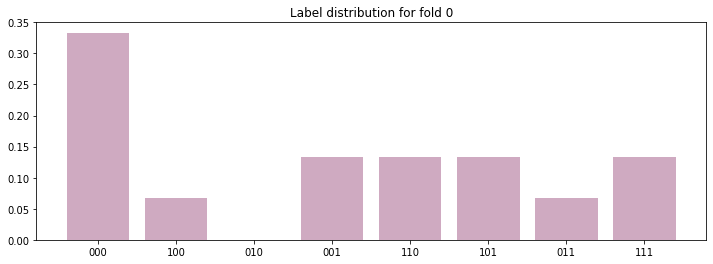

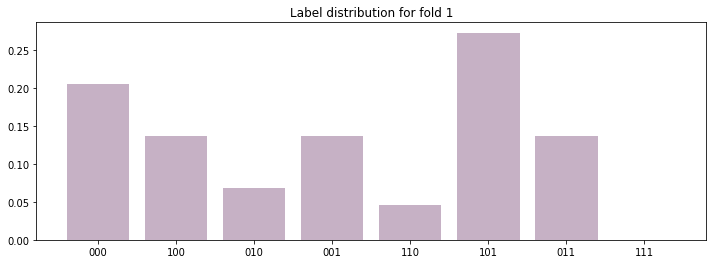

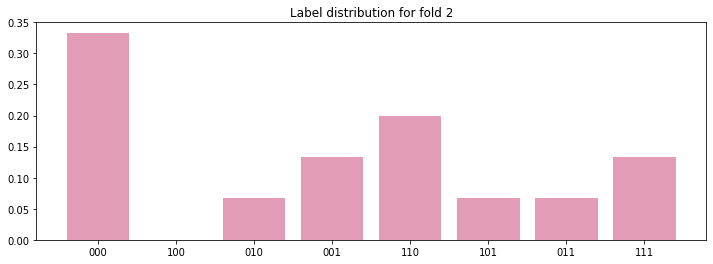

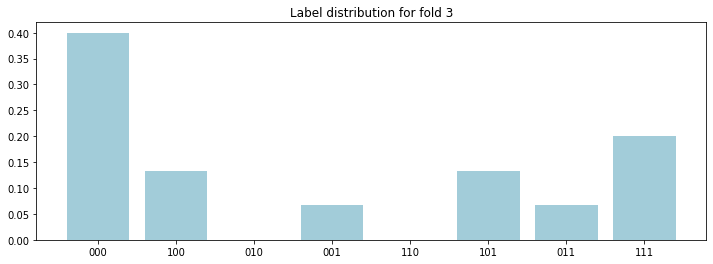

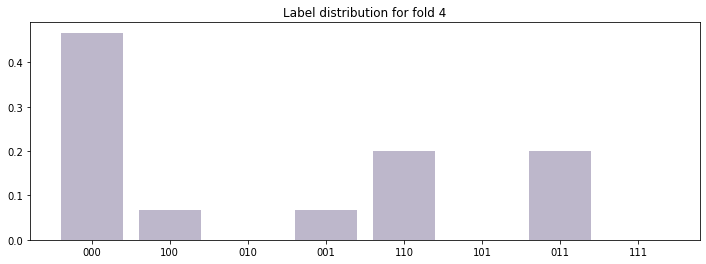

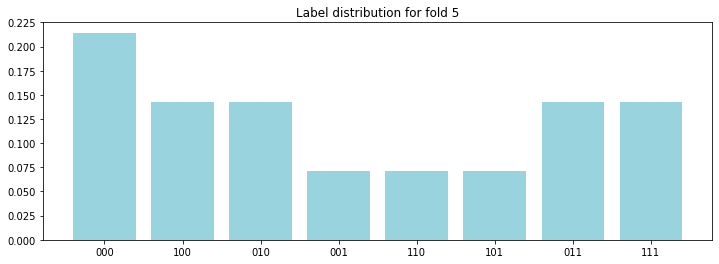

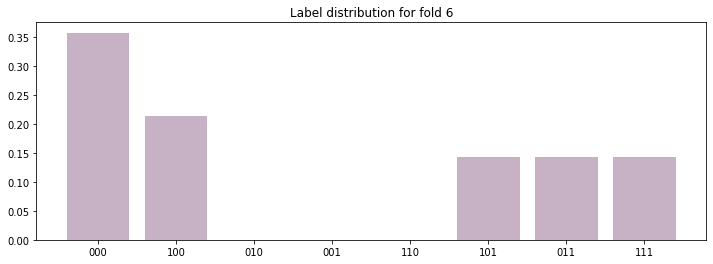

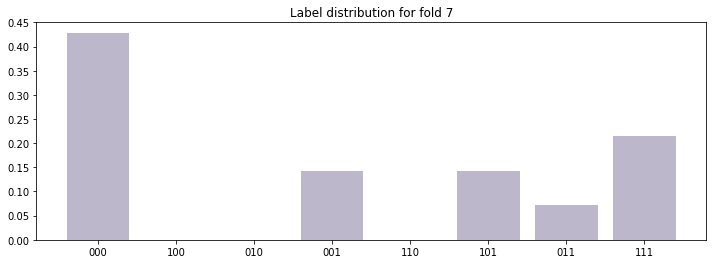

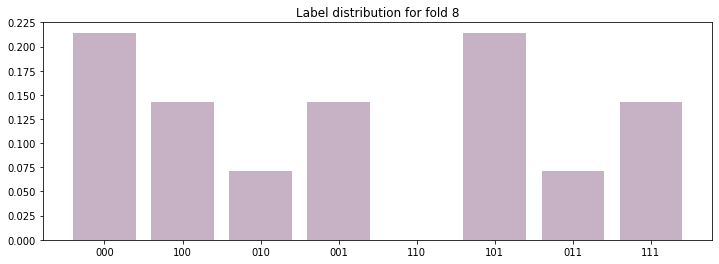

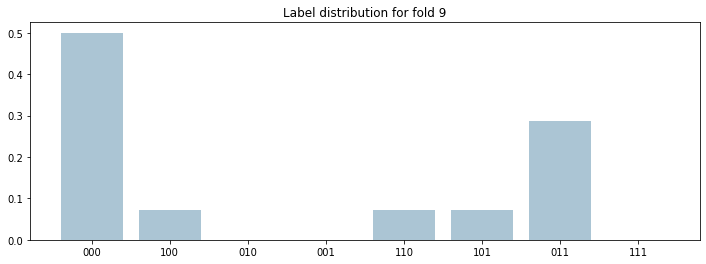

In [13]:
fold_map = fold_labels['folds'].unique()
fold_map.sort()
for fold in fold_map:
    fold_df = fold_labels[fold_labels['folds'] == fold]
    
    heights = []
    for lab in label_map:
        if lab in fold_df['labels'].unique():
            lb_df = fold_df[fold_df['labels'] == lab]
            h = len(lb_df) / len(fold_df)
            heights.append(h)
        else:
            heights.append(0)
            
    plt.figure(figsize=(12, 4))
    plt.bar(label_map, heights, color=get_colour(), alpha=0.4)
    plt.title('Label distribution for fold {}'.format(fold))
    plt.show()
    
    



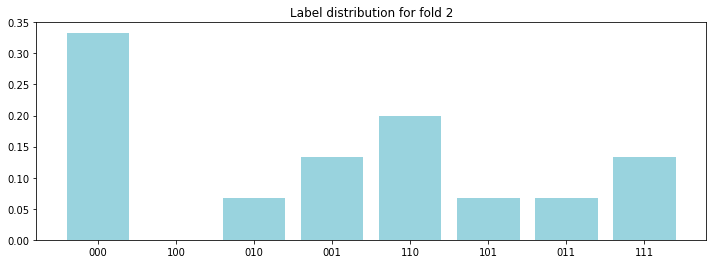

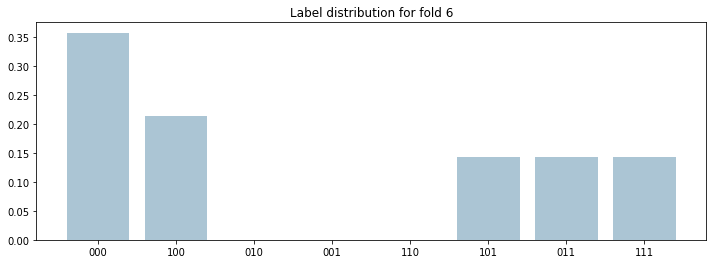

In [14]:
fold_map = fold_labels['folds'].unique()
fold_map.sort()
for fold in [2, 6]:
    fold_df = fold_labels[fold_labels['folds'] == fold]
    
    heights = []
    for lab in label_map:
        if lab in fold_df['labels'].unique():
            lb_df = fold_df[fold_df['labels'] == lab]
            h = len(lb_df) / len(fold_df)
            heights.append(h)
        else:
            heights.append(0)
            
    plt.figure(figsize=(12, 4))
    plt.bar(label_map, heights, color=get_colour(), alpha=0.4)
    plt.title('Label distribution for fold {}'.format(fold))
    plt.show()
    
    


## Stratification on permutation

In [24]:
experiment_path = '../experiments/test_plot/stateaction_secondslstm_12/binconcepts/lstm/raw_full/2021_12_28_4'

In [74]:
heights

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [60]:
fold_df

,folds,labels
6,5,011


In [16]:
pwd

'/Users/cock/kDrive/PhD/Projects/Labs/beerslaw-lab/notebooks/8 - timelines'

In [17]:
cd ../../src

/Users/cock/kDrive/PhD/Projects/Labs/beerslaw-lab/src


In [18]:
with open(experiment_path + 'config.yaml', 'rb') as fp:
    config = pickle.load(fp)
    

In [19]:
config['id_dictionary']['sequences'][0]

{'path': '../data/sequenced_simulations/stateaction_secondslstm/p_2013_lidsvdphyjs_t2_sequenced.pkl',
 'length': 78,
 'learner_id': 'svdphyjs'}

In [20]:
with open(experiment_path + 'config.yaml', 'rb') as fp:
    config = pickle.load(fp)
    id_dictionary = config['id_dictionary']

In [22]:
with open('../data/post_test/rankings.pkl', 'rb') as fp:
    rankings = pickle.load(fp)
    id_rankings = {rankings.iloc[i]['username']: rankings.iloc[i]['ranking'] for i in range(len(rankings))}

In [23]:
id_rankings

{'bezdgyya': '0123',
 'y7p64n6z': '3012',
 '892r4czm': '2031',
 'uhbpoog9': '0213',
 'bed4zkv2': '1023',
 'ytrbygud': '0231',
 'vqebanqv': '2031',
 'mwfdr4ys': '3120',
 'r2e3h3tm': '2031',
 '8ga2zn5h': '2031',
 '3qwayak9': '3012',
 'fh76v5qx': '0231',
 '6tgyhcuh': '0321',
 'd72hfax6': '3012',
 'fryxwskq': '2130',
 'favvtnnf': '3021',
 'qvna6pyz': '0132',
 'addf7f7d': '3012',
 '9sgu2tbg': '0213',
 'k7p5eryf': '2310',
 'pesfpzbv': '3012',
 'jpccnav5': '0321',
 'xtnmv9qf': '2130',
 'r78kg7d3': '1023',
 'uqzxsym7': '3012',
 '8jp62suc': '2013',
 '63v3czy6': '0213',
 '88kjzd8b': '0231',
 '7hrf6cdu': '3012',
 'vwfpuqaz': '3102',
 '3w54b2bu': '2103',
 's78drqcg': '3102',
 '8rtwmb8t': '3012',
 'uthx49rq': '2310',
 'bjy2zpww': '0321',
 'zy256ycq': '0123',
 'fu6nsdhs': '2031',
 'm3d89p29': '3210',
 '5h9umyr6': '2031',
 '4b4dkjuw': '0123',
 '46bty2zg': '3012',
 'z8hvrhwb': '3012',
 'my6csh6m': '0321',
 'krd7m9vb': '3120',
 'yc3vmnuf': '1320',
 '2ae6q3hw': '2031',
 '2hr6mkdc': '3120',
 '8nh4zvcp': 